## 定义工具

In [10]:
import base64, json, datetime
import pygame
from langchain_core.tools import tool
from pathlib import Path
from openai import OpenAI
from operator import itemgetter
from typing import Dict, List, Union
from langchain_core.messages import AIMessage
from langchain_core.runnables import (
    Runnable,
    RunnableLambda,
    RunnableMap,
    RunnablePassthrough,
)

@tool
def set_camera_to(entity_id: str) -> bool:
    """Set the camera to a specific entity."""
    return True

@tool
def set_speech(text: str) -> bool:
    """Generate speech from text and play it."""
    current_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    text_prefix = text[:10].replace(" ", "_")
    speech_file_path = f"output/{current_time}-{text_prefix}.mp3"
    
    with OpenAI().audio.speech.with_streaming_response.create(
        model="tts-1",
        voice="alloy",
        input=text
    ) as response:
        response.stream_to_file(speech_file_path)

    play_audio(speech_file_path)
    return True

tools = [set_camera_to, set_speech]

def call_tools(msg: AIMessage) -> Runnable:
    """Simple sequential tool calling helper."""
    tool_map = {tool.name: tool for tool in tools}
    tool_calls = msg.tool_calls.copy()
    for tool_call in tool_calls:
        tool_call["output"] = tool_map[tool_call["name"]].invoke(tool_call["args"])
    return tool_calls

def obs_cockpit(scenario):
    with open(f"data/{scenario}-cockpit.json", "r") as f:
        cockpit_data = json.load(f)
    return json.dumps(cockpit_data)

def obs_gaze_hmap(scenario):
    img_path =  f"data/{scenario}-1.png"
    return encode_image(img_path)

def obs_hctrl():
    pass

def obs_sensor():
    pass

def obs_hview():
    pass

def obs_eye():
    pass

def play_audio(audio_file_path):
    pygame.init()
    pygame.mixer.init()

    pygame.mixer.music.load(audio_file_path)
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

{'scenario': {'title': 'Scenario'}, 'entity_id': {'title': 'Entity Id', 'type': 'string'}}


## 设置 Prompt

In [12]:
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    HumanMessagePromptTemplate
)

system_messages = "You are a copilot in car cockpit, your aim is to help human driver. Given data below, what should you do to help the human driver in this case? Use tools provided to take actions and explain why."

data_input_template = [
    {"type": "text", "text": "{data_cockpit}"},
    {
        "type": "image_url",
        "image_url": {
            "url": "{data_gaze_hmap}",
            "detail": "high"
        }
    }
]

prompt = ChatPromptTemplate.from_messages([
    ("system", system_messages),
    MessagesPlaceholder(variable_name="history_messages"),
    HumanMessagePromptTemplate.from_template(data_input_template)
])

## 载入模型

In [11]:
import dotenv
from langchain_openai import ChatOpenAI

# Set env var OPENAI_API_KEY or load from a .env file:
dotenv.load_dotenv()

lmm_chat = ChatOpenAI(model="gpt-4-turbo")
lmm_with_tools = lmm_chat.bind_tools(tools)

## 设置 Memory

In [13]:
from langchain.memory import ChatMessageHistory

chat_history = ChatMessageHistory()

## 编排 HCopilot

In [1]:
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory

chain = prompt | lmm_with_tools | call_tools
hcopilot = RunnableWithMessageHistory(
    chain,
    lambda session_id: chat_history,
    input_messages_key="data_cockpit",
    history_messages_key="history_messages",
)

# memory = ConversationBufferMemory(memory_key="history_messages", return_messages=True, input_key="data_cockpit")
# hcopilot = LLMChain(
#     llm=lmm_with_tools,
#     prompt=prompt,
#     verbose=True,
#     memory=memory
# )

NameError: name 'prompt' is not defined

## 载入数据

In [14]:
scenario = "change_line"

# with open(f"data/{scenario}-cockpit.json", "r") as f:
#     cockpit_data = json.load(f)
#     cockpit_data_str = json.dumps(cockpit_data)

# gaze_hmap_b64 = encode_image(f"data/{scenario}-1.png")
# gaze_hmap_url = f"data:image/png;base64,{gaze_hmap_b64}"
# gaze_hmap_url = "https://lsky.metattri.com/i/2024/04/30/662fe044beb9f.png"

data_input = {
    "cockpit": obs_cockpit(scenario),
    "gaze_hmap": f"data:image/png;base64,{obs_gaze_hmap(scenario)}"
}

print(data_input["cockpit"])

{"timestamp": "2024-04-18T04:50:00Z", "timezone": "UTC", "data_version": "1.0", "vehicle": [{"id": "v-ego", "speed": {"value": 5.67, "unit": "m/s", "valid": true}, "acceleration": {"value": 0.5, "unit": "m/s^2", "valid": true}, "direction": {"value": 90, "unit": "degrees", "valid": true}, "location": {"value": {"x": 0, "y": 0, "z": 0}, "unit": "meters", "valid": true}, "bounding_box": {"value": {"width": 1.8, "length": 4.3, "height": 1.5}, "unit": "meters"}, "relative_distance": {"value": 0, "unit": "meters"}}, {"id": "v-001", "speed": {"value": 3.25, "unit": "m/s", "valid": true}, "acceleration": {"value": -0.2, "unit": "m/s^2", "valid": true}, "direction": {"value": 270, "unit": "degrees", "valid": true}, "location": {"value": {"x": -50, "y": 30, "z": 0}, "unit": "meters", "valid": true}, "bounding_box": {"value": {"width": 1.8, "length": 4.3, "height": 1.5}, "unit": "meters"}, "relative_distance": {"value": 58.51, "unit": "meters"}}], "human_driver": {"id": "d-ego", "control": {"W":

## Main

In [18]:
# chat_history.messages
msg = hcopilot.invoke(
    {
        "data_cockpit": data_input["cockpit"],
        "data_gaze_hmap": data_input["gaze_hmap"],
        "configurable": {"session_id": "unused"},
    }
)

msg.tools_calls


AttributeError: 'dict' object has no attribute 'tools_calls'



> Entering new LLMChain chain...
Prompt after formatting:
System: You are a copilot in car cockpit, your aim is to help human driver. You can also see the gaze heatmap of the human driver. You have access to various sensors and cameras in the car. You can control the camera to look at different entities outside the car, and speak to the human driver. Given data below, what should you do to help the human driver in this case? Give examples of actions you can take and explain why you would take them.
Human: {"timestamp": "2024-04-18T04:50:00Z", "timezone": "UTC", "data_version": "1.0", "vehicle": [{"id": "v-ego", "speed": {"value": 5.67, "unit": "m/s", "valid": true}, "acceleration": {"value": 0.5, "unit": "m/s^2", "valid": true}, "direction": {"value": 90, "unit": "degrees", "valid": true}, "location": {"value": {"x": 0, "y": 0, "z": 0}, "unit": "meters", "valid": true}, "bounding_box": {"value": {"width": 1.8, "length": 4.3, "height": 1.5}, "unit": "meters"}, "relative_distance": {"v
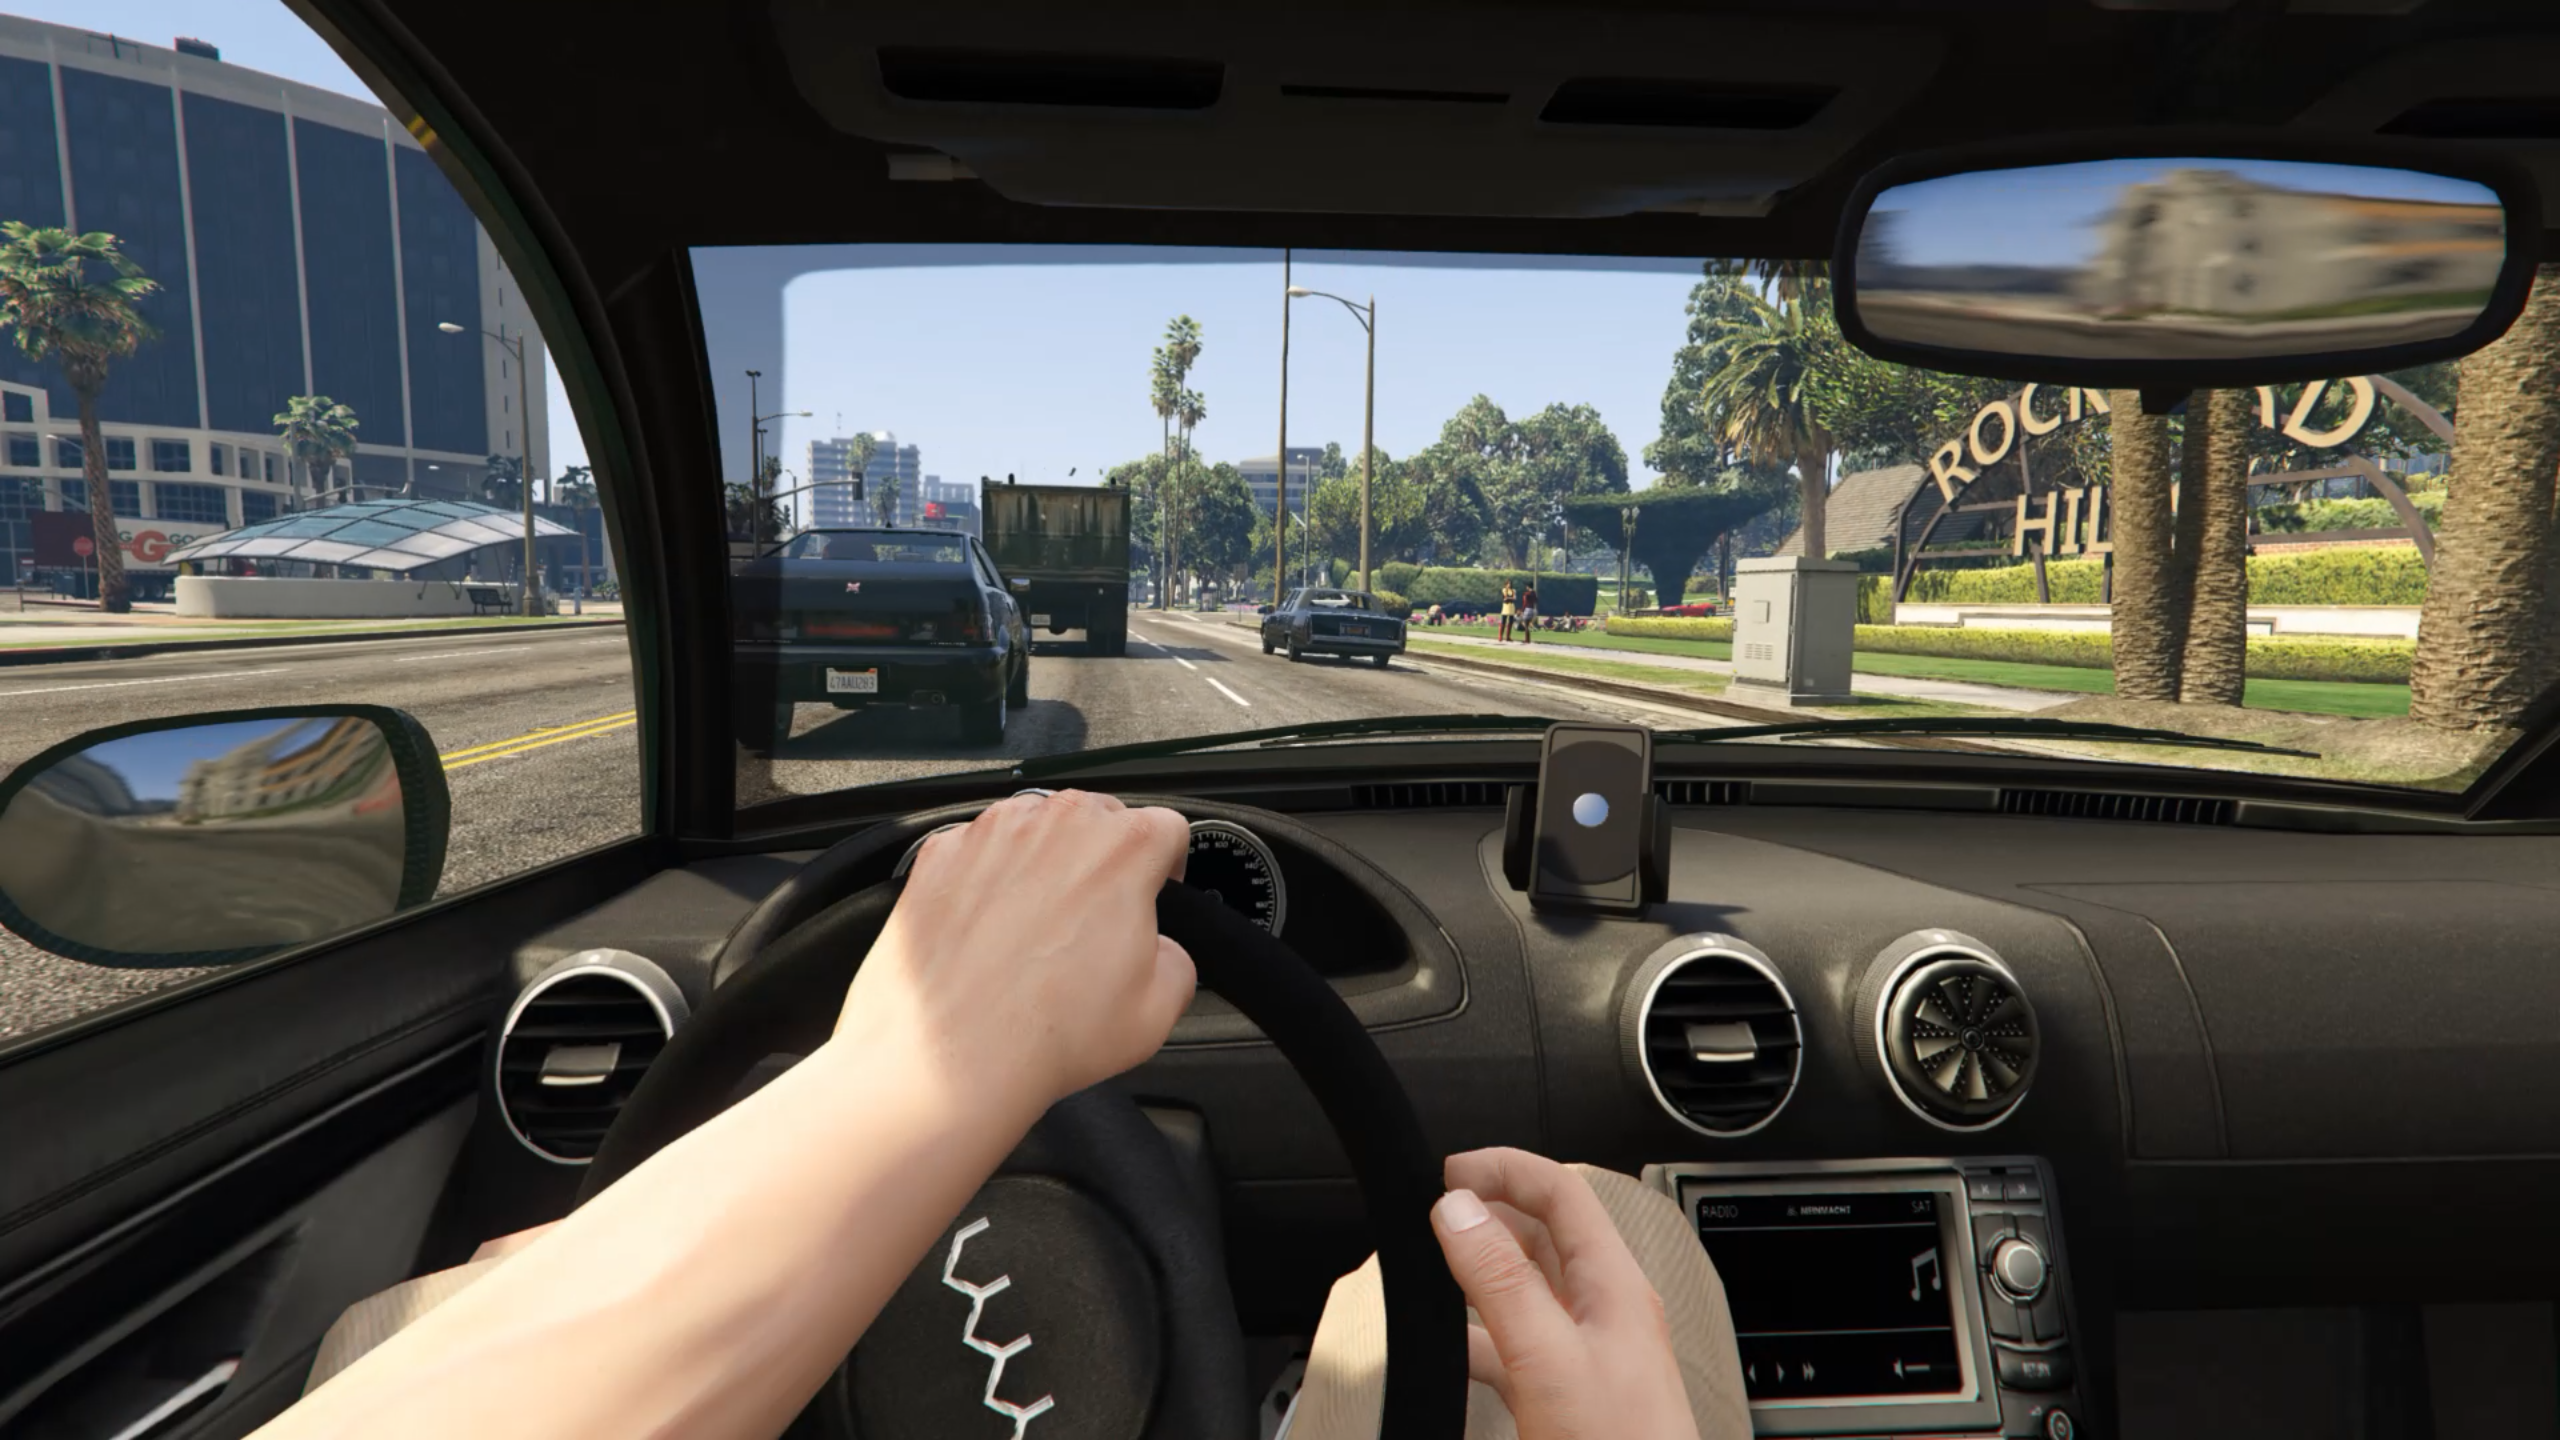

{'history_messages': [HumanMessage(content='{"timestamp": "2024-04-18T04:50:00Z", "timezone": "UTC", "data_version": "1.0", "vehicle": [{"id": "v-ego", "speed": {"value": 5.67, "unit": "m/s", "valid": true}, "acceleration": {"value": 0.5, "unit": "m/s^2", "valid": true}, "direction": {"value": 90, "unit": "degrees", "valid": true}, "location": {"value": {"x": 0, "y": 0, "z": 0}, "unit": "meters", "valid": true}, "bounding_box": {"value": {"width": 1.8, "length": 4.3, "height": 1.5}, "unit": "meters"}, "relative_distance": {"value": 0, "unit": "meters"}}, {"id": "v-001", "speed": {"value": 3.25, "unit": "m/s", "valid": true}, "acceleration": {"value": -0.2, "unit": "m/s^2", "valid": true}, "direction": {"value": 270, "unit": "degrees", "valid": true}, "location": {"value": {"x": -50, "y": 30, "z": 0}, "unit": "meters", "valid": true}, "bounding_box": {"value": {"width": 1.8, "length": 4.3, "height": 1.5}, "unit": "meters"}, "relative_distance": {"value": 58.51, "unit": "meters"}}], "hum

In [16]:
# chain_with_memory.invoke(
#     {
#         "data_cockpit": "what is the speed?",
#         "data_gaze_hmap": f"data:image/png;base64,{data_input['gaze_hmap']}"
#     }
# )

# memory.load_memory_variables({})